In [ ]:
import json
import time
import re
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from glob import glob

from nltk.stem import WordNetLemmatizer


from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression

In [13]:
def json_to_dataframe(file_path):
    return pd.read_json(file_path, lines=True)

files = glob("data/*.jsonl")
dfs = [json_to_dataframe(file) for file in files]
df = pd.concat(dfs, ignore_index=True)

#  Preprocessing

In [14]:
# Creating the answers_df
human_df = pd.DataFrame({'questions': df['question'], 'answers': df['human_answers'], 'is_human': 1 })
gpt_df = pd.DataFrame({'questions': df['question'], 'answers': df['chatgpt_answers'], 'is_human': 0})
answers_df = pd.concat([human_df, gpt_df], axis=0, ignore_index=True)

# Cleaning
answers_df = answers_df.explode('answers', ignore_index=True)
answers_df = answers_df.dropna(subset=['answers'], ignore_index=True)
answers_df = answers_df[~answers_df['answers'].str.endswith('There was an error generating a response')]
answers_df = answers_df[~answers_df['answers'].str.endswith('Log out')]
deprecated_df = answers_df[answers_df['answers'].str.len() != 0]

# Importing other_df
csv = pd.read_csv("data/hack_train.csv")
csvFull = csv.rename(columns={'text': 'answers', "label" : "is_human"})
newly_df = csvFull.drop(columns="src")

display(deprecated_df.head())
newly_df.head()

,questions,answers,is_human
0,what composer used sound mass,"Composers and works include Barbara Kolb , Pau...",1
1,where did the persian war take place,The Greco-Persian Wars (also often called the ...,1
2,what are add ons,"Plug-in (computing) , a piece of software whic...",1
3,how does a dredge work?,Dredging is an excavation activity or operatio...,1
4,what classes are considered humanities,The humanities are academic disciplines that s...,1


,answers,is_human
0,Little disclaimer: this deals with US laws and...,1
1,"Read: Mentally Retarded Downs. See, we've got ...",1
2,"If any of you frequent rbadhistory, there is a...",1
3,"I believe in a flat tax system, where everyone...",1
4,"Edit: Ok guy's, my views have been changed on ...",1


In [15]:
X = newly_df['answers']
y = newly_df['is_human']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

# Analyse du Dataset

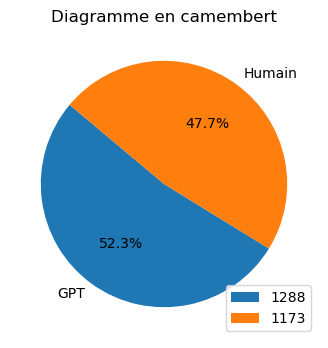

In [65]:
newly_df

humain = newly_df[newly_df["is_human"] == 1].copy()
gpt = newly_df[newly_df["is_human"] == 0].copy()

HUMAINmean = round(humain['answers'].apply(len).mean())
GPTmean = round(gpt['answers'].apply(len).mean())

plt.figure(figsize=(4, 4)) 
plt.pie([GPTmean, HUMAINmean], labels=['GPT', 'Humain'], autopct='%1.1f%%', startangle=140)
plt.legend([GPTmean, HUMAINmean], loc='lower right', bbox_to_anchor=(1, 0))

plt.title('Diagramme en camembert')
plt.show()

In [52]:
def CutTenWords(x):
    return " ".join(x.split(' ')[:10])

gpt["Similarity"] = gpt.answers.apply(CutTenWords)
value_counts = gpt["Similarity"].value_counts()

# Convert to DataFrame
value_counts_df = value_counts.reset_index()
value_counts_df.columns = ['Unique_Value', 'Counts'] 

value_counts_df.head(40)

,Unique_Value,Counts
0,Uber is having a very public fight right now with,53
1,Media playback is not supported on this device...,52
2,It all sound the same to me. And to be,51
3,European Union law is applied by the courts of...,51
4,I have been noticing the news about police off...,51
5,I have recently been told that my pro-life pos...,49
6,WARNING: WALL OF TEXT!!! I also jump from topi...,47
7,As a society we have limited resources. We hav...,46
8,"In 2013, the Peabody Awards honoured Doctor Wh...",27
9,"Duties vary, but a lot of it is essentially di...",27


In [67]:
humain["Similarity"] = humain.answers.apply(CutTenWords)
value_counts = humain["Similarity"].value_counts()

# Convert to DataFrame
value_counts_df = value_counts.reset_index()
value_counts_df.columns = ['Unique_Value', 'Counts'] 

value_counts_df.head(10)

,Unique_Value,Counts
0,Media playback is not supported on this device...,2
1,"Yer not alone in askin', and kind strangers ha...",2
2,I used to lived in Phoenix Arizona. On my way,2
3,Media playback is not supported on this device...,2
4,Media playback is not supported on this device...,2
5,Media playback is unsupported on your device 1...,2
6,Media playback is not supported on this device...,2
7,"I actually had two funny ideas for this, could...",2
8,Media playback is not supported on this device...,2
9,Media playback is not supported on this device...,2


# Logistic Regression

In [23]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Accuracy: ", accuracy_score(y_test, y_pred))

    print("F1 score: ", f1_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

Accuracy:  0.9342661034846885
F1 score:  0.935575679172057


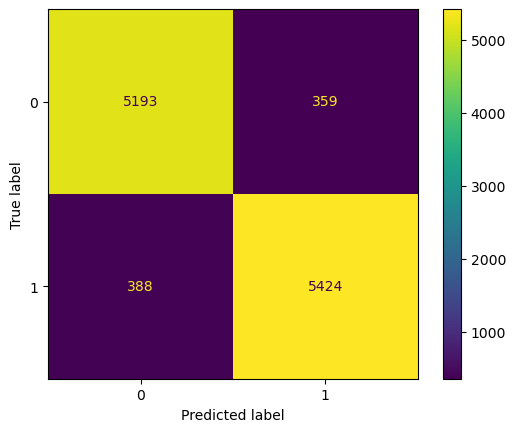

In [46]:
lr_classifier = make_pipeline(TfidfVectorizer(ngram_range=(2,2)), LogisticRegression(C=10,random_state=42, solver='newton-cg', max_iter=10000))
lr_classifier.fit(X_train.values, y_train)
evaluate_model(lr_classifier, X_test, y_test)

# Analyse des performances

In [20]:

crash_test = """In the vast expanse of the universe, billions of stars twinkle in the darkness of space. Galaxies spiral and collide, nebulae glow with ethereal light, and black holes devour everything in their path. It is a place of wonder and mystery, where the laws of physics are pushed to their limits and the secrets of the cosmos remain elusive.
On a small blue planet orbiting an average star, life flourishes in all its diversity. From the depths of the oceans to the heights of the mountains, countless species of plants and animals thrive in a delicate balance. Humans, with their intelligence and ingenuity, have built civilizations, explored the world, and reached for the stars.
But even as humanity has made great strides in science and technology, there are still many unanswered questions about the universe. What lies beyond the edge of the observable universe? Are we alone in the cosmos, or are there other intelligent civilizations out there? And what is the ultimate fate of the universe itself?
As we ponder these questions, we are reminded of our place in the cosmos - small and insignificant, yet capable of great things. We are explorers, adventurers, seekers of knowledge and understanding. And as we gaze up at the stars, we are filled with a sense of wonder and awe at the vastness and beauty of the universe.
So let us continue to explore, to discover, to dream. For the universe is a place of infinite possibilities, and there is still so much left to learn and to explore. As long as we dare to dream and reach for the stars, the journey will never end. I will start my text again: 
In the vast expanse of the cosmos, stretching across billions of light-years, galaxies drift like islands in a sea of darkness. Stars twinkle like diamonds, nebulae glow with ethereal light, and black holes lurk in the depths of space. It is a place of unimaginable beauty and mystery, where the laws of physics are pushed to their limits and the secrets of the universe remain tantalizingly out of reach.
On a small blue planet nestled in the outskirts of a spiral galaxy, life teems in all its forms. From the towering redwoods of the ancient forests to the microscopic creatures that dwell in the depths of the oceans, the planet is a symphony of life and diversity. Humans, with their curiosity and ambition, have built civilizations, explored the farthest reaches of the globe, and ventured into the unknown depths of space.
But even as humanity has made great strides in understanding the world around them, there are still many mysteries left to unravel. What lies beyond the edge of the observable universe? Are there other intelligent beings out there, gazing up at the same stars and wondering about their place in the cosmos? And what is the ultimate fate of the universe itself?
As we ponder these questions, we are reminded of our own insignificance in the grand scheme of things. We are but a speck of dust in the vastness of the cosmos, a fleeting moment in the endless march of time. And yet, in our brief existence, we have achieved so much - we have explored the farthest reaches of space, unlocked the secrets of the atom, and harnessed the power of the stars themselves.
So let us continue to dream, to explore, to reach for the stars. For the universe is a place of infinite possibilities, and there is still so much left to discover. As long as there are questions left unanswered and mysteries left unsolved, the journey will never truly be over. And so we gaze up at the night sky, filled with wonder and awe at the beauty and majesty of the cosmos, and we dream of what lies beyond.
"""

tokens = crash_test.split()
print("Nombre de tokens:", len(tokens))

Nombre de tokens: 636


In [43]:
def lr_classifier_execution_time():
    start_time = time.time()
    lr_classifier.predict([crash_test])
    print("Regression Logistique temps d'exécution:", time.time() - start_time, "secondes")

def fnn_classifier_execution_time():
    start_time = time.time()
    #FUNC
    print("FNN temps d'exécution:", time.time() - start_time, "secondes")

def xgbf_execution_time():
    start_time = time.time()
    #FUNC
    print("XGBoost temps d'exécution:", time.time() - start_time, "secondes")

def llm_execution_time():
    start_time = time.time()
    # FUNC
    print("LLM temps d'exécution:", time.time() - start_time, "secondes")

In [45]:
lr_classifier_execution_time()

Regression Logistique temps d'exécution: 0.03429126739501953 secondes
